In [2]:
import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

import numpy as np

import pandas as pd

import os,sys

import copy

import h3

import branca.colormap as cmp

from shapely.geometry import Point, Polygon

import math

import random

import time

import datetime

import scipy.stats as stats

import warnings

warnings.filterwarnings('ignore')

## 01 Parameters

In [3]:
day='2020-12-01'

booking_fare={'A':3,'B':2.5}

time_unit={'A':0.5,'B':0.4}

minimum_fare={'A':6,'B':7}

## 02 Pricing function

In [4]:
'''Surging Pricing'''

class Price(object):
    
    def __init__(self,booking_fare,time_unit,minimum_fare):
        
        self.booking_fare=booking_fare
        
        self.time_unit=time_unit
        
        self.minimum_fare=minimum_fare
        
    def Get_fare(self,service_time,platform):

        fare=self.booking_fare[platform]+self.time_unit[platform]*service_time

        fare=max(fare,self.minimum_fare[platform])

        return fare
    
Price=Price(booking_fare,time_unit,minimum_fare)

## 03 Loading data

In [5]:
Order_df=pd.read_csv(os.path.join('Order_df_'+str(day)+'.csv'))

Order_df=Order_df.drop(columns=['Unnamed: 0'])

Order_df

,Order_id,Driver_id,Arrive_step,Response_step,Pickup_step,Pickup_Latitude,Pickup_Longitude,Dropoff_Latitude,Dropoff_Longitude,Pickup_Grid,...,Travel_dis,Travel_time,date,Matching_patience,Fare,Travel_duration,Travel_distance,Fare_A,Fare_B,Travel_minute
0,O3164,Waiting,2520,86400,86400,40.754468,-73.964315,40.741961,-73.977330,892a100d6afffff,...,2404.365411,43,2020-12-01,5.0,7.608736,7,1.490707,6.5,7.0,7
1,O3023,Waiting,2520,86400,86400,40.761293,-73.969216,40.705866,-74.015789,892a100d617ffff,...,9643.183140,173,2020-12-01,5.0,22.812854,28,5.978774,17.0,13.7,28
2,O1659,Waiting,2520,86400,86400,40.793813,-73.956710,40.755719,-73.987493,892a1008d6bffff,...,6523.698306,117,2020-12-01,6.0,16.278213,19,4.044693,12.5,10.1,19
3,O2033,Waiting,2520,86400,86400,40.746387,-73.991349,40.769579,-73.956629,892a100d2cfffff,...,5561.580537,100,2020-12-01,7.0,14.184315,16,3.448180,11.0,8.9,16
4,O3016,Waiting,2520,86400,86400,40.744064,-73.988888,40.759098,-73.968666,892a100d21bffff,...,3356.286644,60,2020-12-01,7.0,9.691571,10,2.080898,8.0,7.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7222,O7096,Waiting,3599,86400,86400,40.753147,-73.999529,40.773106,-73.985229,892a1072523ffff,...,3270.450519,58,2020-12-01,6.0,9.248439,9,2.027679,7.5,7.0,9
7223,O11395,Waiting,3599,86400,86400,40.747148,-74.002871,40.719936,-73.990109,892a1072197ffff,...,4003.448022,72,2020-12-01,5.0,11.093741,12,2.482138,9.0,7.3,12
7224,O9044,Waiting,3599,86400,86400,40.740831,-73.986430,40.761017,-73.981455,892a100d203ffff,...,2769.213778,49,2020-12-01,4.0,8.354597,8,1.716913,7.0,7.0,8
7225,O10529,Waiting,3599,86400,86400,40.777589,-73.965240,40.748137,-73.979418,892a1008973ffff,...,4353.964339,78,2020-12-01,5.0,11.824051,13,2.699458,9.5,7.7,13


## 04 Arriving rate and culmulative orders

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


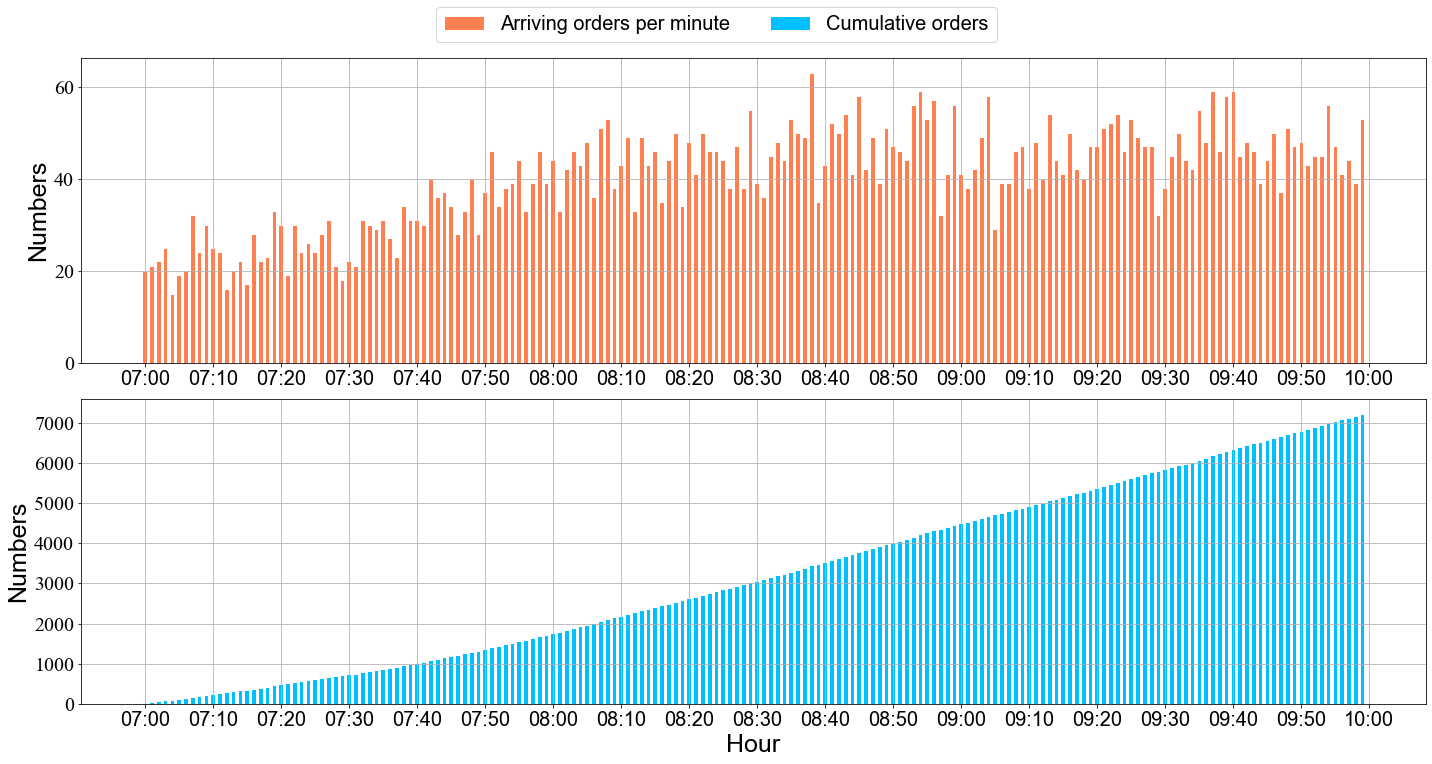

In [6]:
'''Statistics'''

def Get_minute(step):
    
    return int(step/6)

Order_STAT=Order_df.groupby(['Arrive_step']).count()

Order_STAT['Step']=Order_STAT.index

Order_STAT=Order_STAT.reset_index(drop=True)

Order_STAT=Order_STAT.rename(columns={'Order_id':'Order_num'})

Order_STAT=Order_STAT[['Step','Order_num']]

Order_STAT['minute']=Order_STAT.apply(lambda x:Get_minute(x['Step']),axis=1)

Order_STAT=Order_STAT.groupby('minute').sum()

Order_STAT['minute']=Order_STAT.index

Order_STAT=Order_STAT.reset_index(drop=True)

Order_STAT["Cumulative_orders"]=0


for idx,col in Order_STAT.iterrows():
    
    if idx!=0:
    
        Order_STAT.loc[idx,'Cumulative_orders']=Order_STAT.loc[idx-1,'Cumulative_orders']+Order_STAT.loc[idx,'Order_num']
        
    else:
        
        Order_STAT.loc[idx,'Cumulative_orders']=Order_STAT.loc[idx,'Order_num']
        

Order_STAT=Order_STAT[['minute','Order_num','Cumulative_orders']]

Order_STAT

'''Plot Figure'''

figsize = 20,10

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 25}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

figure, ax1 = plt.subplots(2,1,figsize=figsize)

for i in range(2):

    labels = ax1[i].get_xticklabels() + ax1[i].get_yticklabels()

    [label.set_fontsize(20) for label in labels]

    [label.set_fontname('Times New Roman') for label in labels]
    
    
    

'''Plot'''

cumulative=[0  for i in list(Order_STAT['minute'])]

ax1[0].bar(Order_STAT['minute'],\
        Order_STAT['Order_num'],\
        bottom=cumulative,
        width = 0.7,\
        facecolor = 'coral',\
        edgecolor = 'white',\
        label='Arriving orders per minute')
    


xmajorLocator   = MultipleLocator(10)

ax1[0].xaxis.set_major_locator(xmajorLocator)

ymajorLocator1   = MultipleLocator(20)

ax1[0].yaxis.set_major_locator(ymajorLocator1)

ax1[0].set_ylabel('Numbers',font_label)

ax1[0].grid()

ax1[0].set_xticklabels(['','07:00', '07:10','07:20','07:30','07:40','07:50',\
                        '08:00', '08:10','08:20','08:30','08:40','08:50',\
                        '09:00', '09:10','09:20','09:30','09:40','09:50','10:00'],font_legend)


cumulative=[0  for i in list(Order_STAT['minute'])]

ax1[1].bar(Order_STAT['minute'],\
        Order_STAT['Cumulative_orders'],\
        bottom=cumulative,
        width = 0.7,\
        facecolor = 'deepskyblue',\
        edgecolor = 'white',\
        label='Cumulative orders')
    


xmajorLocator   = MultipleLocator(10)

ax1[1].xaxis.set_major_locator(xmajorLocator)

ymajorLocator1   = MultipleLocator(1000)

ax1[1].yaxis.set_major_locator(ymajorLocator1)

ax1[1].set_ylabel('Numbers',font_label)

ax1[1].set_xlabel('Hour',font_label)

ax1[1].grid()

ax1[1].set_xticklabels(['','07:00', '07:10','07:20','07:30','07:40','07:50',\
                        '08:00', '08:10','08:20','08:30','08:40','08:50',\
                        '09:00', '09:10','09:20','09:30','09:40','09:50','10:00'],font_legend)


lines = []

labels = []

for ax in figure.axes:
    
    axLine, axLabel = ax.get_legend_handles_labels()
    
    lines.extend(axLine)
    
    labels.extend(axLabel)

figure.legend(lines, labels,loc ='upper center',bbox_to_anchor=(0.5, 1.07),prop=font_legend,ncol=2)

plt.tight_layout()

current_fig = plt.gcf() # 'get current figure'



current_fig.savefig('12Demand.eps', format='eps', dpi=1000, bbox_inches = 'tight')


plt.show()

## 05 Pricing

In [7]:
Order_df['Travel_minute']=Order_df.apply(lambda x:int(x['Travel_time']/6),axis=1)

Order_df['Fare_A']=Order_df.apply(lambda x:Price.Get_fare(x['Travel_minute'],'A'),axis=1)

Order_df['Fare_B']=Order_df.apply(lambda x:Price.Get_fare(x['Travel_minute'],'B'),axis=1)

Order_df

,Order_id,Driver_id,Arrive_step,Response_step,Pickup_step,Pickup_Latitude,Pickup_Longitude,Dropoff_Latitude,Dropoff_Longitude,Pickup_Grid,...,Travel_dis,Travel_time,date,Matching_patience,Fare,Travel_duration,Travel_distance,Fare_A,Fare_B,Travel_minute
0,O3164,Waiting,2520,86400,86400,40.754468,-73.964315,40.741961,-73.977330,892a100d6afffff,...,2404.365411,43,2020-12-01,5.0,7.608736,7,1.490707,6.5,7.0,7
1,O3023,Waiting,2520,86400,86400,40.761293,-73.969216,40.705866,-74.015789,892a100d617ffff,...,9643.183140,173,2020-12-01,5.0,22.812854,28,5.978774,17.0,13.7,28
2,O1659,Waiting,2520,86400,86400,40.793813,-73.956710,40.755719,-73.987493,892a1008d6bffff,...,6523.698306,117,2020-12-01,6.0,16.278213,19,4.044693,12.5,10.1,19
3,O2033,Waiting,2520,86400,86400,40.746387,-73.991349,40.769579,-73.956629,892a100d2cfffff,...,5561.580537,100,2020-12-01,7.0,14.184315,16,3.448180,11.0,8.9,16
4,O3016,Waiting,2520,86400,86400,40.744064,-73.988888,40.759098,-73.968666,892a100d21bffff,...,3356.286644,60,2020-12-01,7.0,9.691571,10,2.080898,8.0,7.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7222,O7096,Waiting,3599,86400,86400,40.753147,-73.999529,40.773106,-73.985229,892a1072523ffff,...,3270.450519,58,2020-12-01,6.0,9.248439,9,2.027679,7.5,7.0,9
7223,O11395,Waiting,3599,86400,86400,40.747148,-74.002871,40.719936,-73.990109,892a1072197ffff,...,4003.448022,72,2020-12-01,5.0,11.093741,12,2.482138,9.0,7.3,12
7224,O9044,Waiting,3599,86400,86400,40.740831,-73.986430,40.761017,-73.981455,892a100d203ffff,...,2769.213778,49,2020-12-01,4.0,8.354597,8,1.716913,7.0,7.0,8
7225,O10529,Waiting,3599,86400,86400,40.777589,-73.965240,40.748137,-73.979418,892a1008973ffff,...,4353.964339,78,2020-12-01,5.0,11.824051,13,2.699458,9.5,7.7,13


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

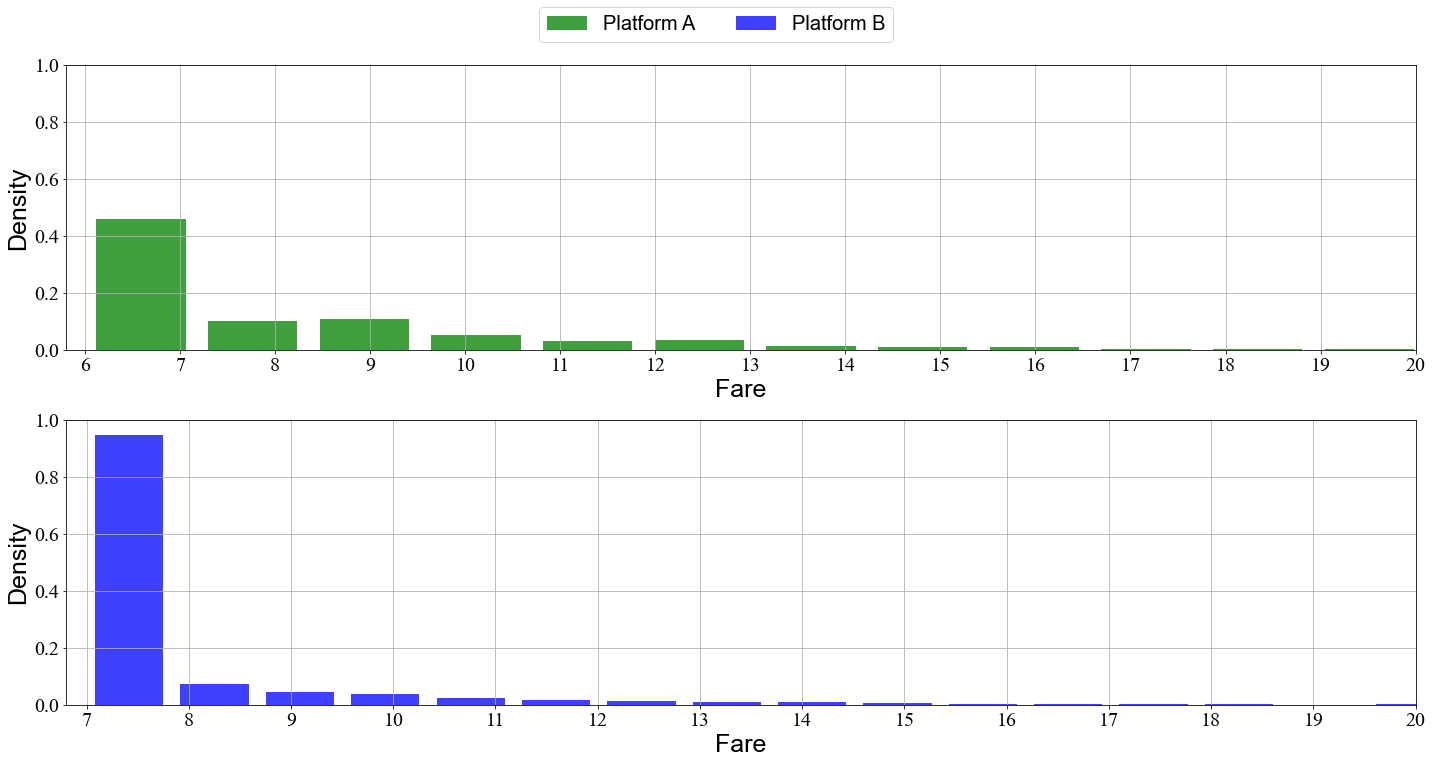

In [8]:
Fare_A=copy.deepcopy(np.array(Order_df['Fare_A'].to_list()))

Fare_B=copy.deepcopy(np.array(Order_df['Fare_B'].to_list()))

'''Plot Figure'''

figsize = 20,10

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 25}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

figure, ax1 = plt.subplots(2,1,figsize=figsize)

for i in range(2):

    labels = ax1[i].get_xticklabels() + ax1[i].get_yticklabels()

    [label.set_fontsize(20) for label in labels]

    [label.set_fontname('Times New Roman') for label in labels]
    
    
    

'''Platform A'''

ax1[0].hist(Fare_A,20,label='Platform A',facecolor='g', density=True, alpha=0.75,rwidth=0.8)

    
xmajorLocator   = MultipleLocator(1)

ax1[0].xaxis.set_major_locator(xmajorLocator)


ax1[0].set_ylabel('Density',font_label)

ax1[0].set_xlabel('Fare',font_label)

ax1[0].grid()

ax1[0].set_xlim([5.8,20])

ax1[0].set_ylim([0,1])


'''Platform A'''

ax1[1].hist(Fare_B,20,label='Platform B',facecolor='b', density=True, alpha=0.75,rwidth=0.8)
    
xmajorLocator = MultipleLocator(1)

ax1[1].xaxis.set_major_locator(xmajorLocator)


ax1[1].set_ylabel('Density',font_label)

ax1[1].set_xlabel('Fare',font_label)

ax1[1].grid()

ax1[1].set_xlim([6.8,20])

ax1[1].set_ylim([0,1])


lines = []

labels = []

for ax in figure.axes:
    
    axLine, axLabel = ax.get_legend_handles_labels()
    
    lines.extend(axLine)
    
    labels.extend(axLabel)

figure.legend(lines, labels,loc ='upper center',bbox_to_anchor=(0.5, 1.07),prop=font_legend,ncol=2)

plt.tight_layout()

current_fig = plt.gcf() # 'get current figure'

current_fig.savefig('13Price.eps', format='eps', dpi=1000, bbox_inches = 'tight')

plt.show()

## 08 Saving

In [9]:
Order_df.to_csv(os.path.join('Order_df_'+str(day)+'.csv'))